# RHme3 tracing the traces

This is a solution for the Rhme3 tracing the traces challenge. This code is based on the jlsca tutorial for Rhme3

In [2]:
# load the tools
using Jlsca.Sca
using Jlsca.Trs
using Jlsca.Align
using Jlsca.Aes
using PyCall
using PyPlot.plot,PyPlot.figure

@pyimport numpy

## Explore the traces

In [9]:
# load the traceset
trs = InspectorTrace("traces.trs");

[x] Skipping unknown tag 70 with length 5
[x] Skipping unknown tag 73 with length 1
[x] Skipping unknown tag 74 with length 1
[x] Skipping unknown tag 75 with length 4
[x] Skipping unknown tag 76 with length 4
[x] Skipping unknown tag 104 with length 4
[x] Skipping unknown tag 105 with length 1
[x] Skipping unknown tag 106 with length 1
Opened traces.trs, #traces 300, #samples 6095 (Float32), #data 32


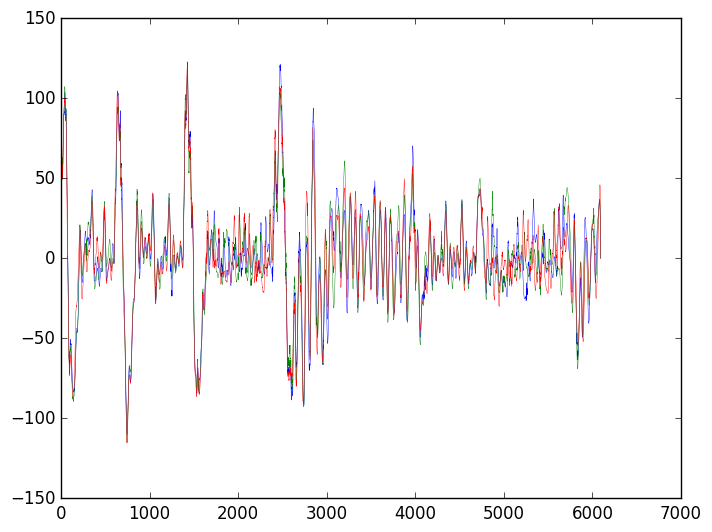

In [10]:
reset(trs)
# read and plot 3 traces with some zoom
((data,samples),eof) = readTraces(trs, 1:3);
plot(samples[1:3,:]', linewidth=.3);

Looking at the overview.png compared to the trace it looks like the trace is at the begninig e.g. 3 peaks followed by a smaller peak

![](overview.png)

Check alignment

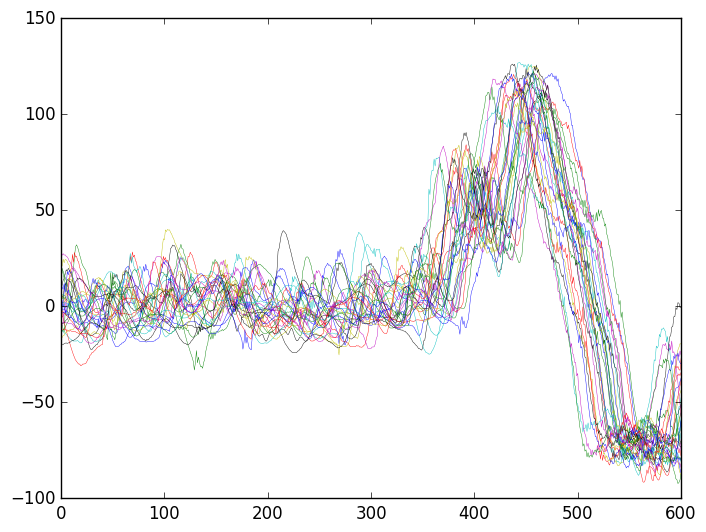

[x] Skipping unknown tag 70 with length 5
[x] Skipping unknown tag 73 with length 1
[x] Skipping unknown tag 74 with length 1
[x] Skipping unknown tag 75 with length 4
[x] Skipping unknown tag 76 with length 4
[x] Skipping unknown tag 104 with length 4
[x] Skipping unknown tag 105 with length 1
[x] Skipping unknown tag 106 with length 1
Opened traces.trs, #traces 300, #samples 6095 (Float32), #data 32


In [17]:
# load the traceset
trs = InspectorTrace("traces.trs");

# read and plot 3 traces with some zoom
((data,samples),eof) = readTraces(trs, 1:30);
plot(samples[1:30,2000:2600]', linewidth=.3);

In [ ]:
# The traces are not well aligned so we need to better align them

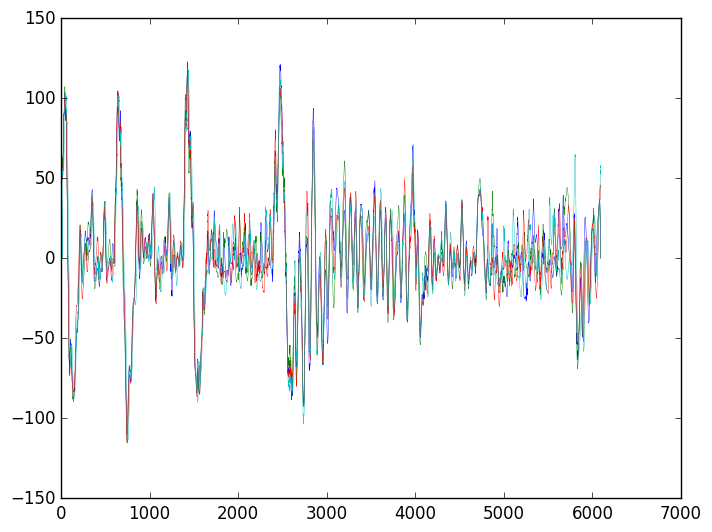

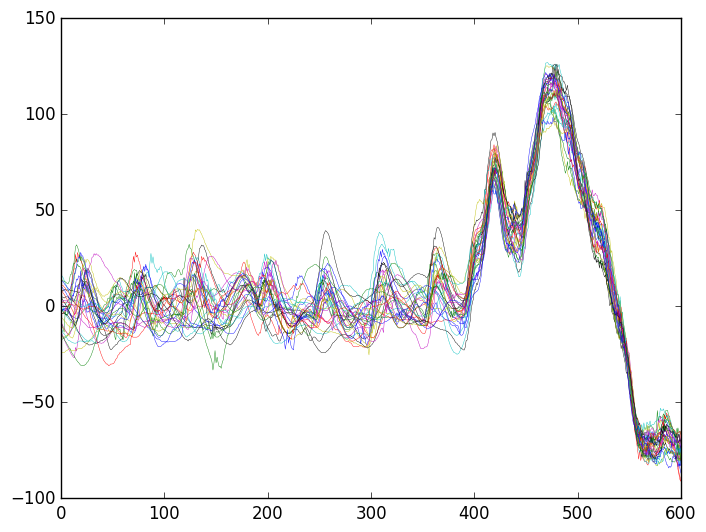

In [20]:
reset(trs)

# selecting the reference pattern in the first races
referencestart = 2300
referenceend = referencestart + 300
reference = trs[1][2][referencestart:referenceend]

# in the search of alignemt, traces will be shifted by max this amount of samples
maxShift = 200

# the rejection threshold
corvalMin = 0.0

# create the alignment engine
alignstate = CorrelationAlignFFT(reference, referencestart, maxShift)

# add the alignment as a sample processing pass
# the end of the next line is somewhat complex I must say :) But it's an experimental toolbox, yay!
addSamplePass(trs, x -> ((shift,corval) = correlationAlign(x, alignstate); corval > corvalMin ? circshift(x, shift) : Vector{eltype(x)}(0)))

# execute the alignment pass by reading the traces
((data,samples),eof) = readTraces(trs, 1:4)

# remove the alignment apss
#popSamplePass(trs)

# see what we've got
plot(samples[1:4,:]', linewidth=.3);
figure()



# read and plot 3 traces with some zoom
((data,samples),eof) = readTraces(trs, 1:30);
plot(samples[1:30,2000:2600]', linewidth=.3);


In [14]:
close(trs)

## Run correlation power analysis
Vanilla CPA on the first round in the good old Hamming weight leakage model

In [15]:
# load the traceset
trs = InspectorTrace("traces.trs");

reset(trs)

# selecting the reference pattern in the first races
referencestart = 2300
referenceend = referencestart + 200
reference = trs[1][2][referencestart:referenceend]

# in the search of alignemt, traces will be shifted by max this amount of samples
maxShift = 200

# the rejection threshold
corvalMin = 0.0

# create the alignment engine
alignstate = CorrelationAlignFFT(reference, referencestart, maxShift)

# add the alignment as a sample processing pass
# the end of the next line is somewhat complex I must say :) But it's an experimental toolbox, yay!
addSamplePass(trs, x -> ((shift,corval) = correlationAlign(x, alignstate); corval > corvalMin ? circshift(x, shift) : Vector{eltype(x)}(0)))

params = AesSboxAttack()
params.dataOffset = 1       # plaintext starts from byte 1
params.direction = FORWARD
#params.keyLength = KL192
params.keyLength = KL128
params.analysis = IncrementalCPA()
params.analysis.leakages = [HW()]
#params.xor = true
numberOfTraces = length(trs);

setPostProcessor(trs, IncrementalCorrelation())
key = sca(trs, params, 1, numberOfTraces)

[x] Skipping unknown tag 70 with length 5
[x] Skipping unknown tag 73 with length 1
[x] Skipping unknown tag 74 with length 1
[x] Skipping unknown tag 75 with length 4
[x] Skipping unknown tag 76 with length 4
[x] Skipping unknown tag 104 with length 4
[x] Skipping unknown tag 105 with length 1
[x] Skipping unknown tag 106 with length 1
Opened traces.trs, #traces 300, #samples 6095 (Float32), #data 32

Jlsca running in Julia version: 0.6.0, 1 processes/1 workers/1 threads per worker

AES Sbox IncrementalCPA attack parameters
leakages:   Jlsca.Sca.Leakage[Jlsca.Sca.HW()]
mode:       CIPHER
key length: KL128
direction:  FORWARD
target:     Sbox out
data at:    1
key bytes:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

phase: 1

Running processor Jlsca.Sca.IncrementalCorrelation on all traces, using trace set with 1 data passes, 1 sample passes


Processing traces 1:300.. 100%|█████████████████████████| Time: 0:00:04


Results @ 300 traces
kb: 1
rank:   1, candidate: 0xca, peak: 0.365366 @ 2663
rank:   2, candidate: 0x74, peak: 0.260609 @ 769
rank:   3, candidate: 0x6e, peak: 0.249993 @ 4548
rank:   4, candidate: 0xd8, peak: 0.248468 @ 3018
rank:   5, candidate: 0xba, peak: 0.247693 @ 2308
kb: 2
rank:   1, candidate: 0xfe, peak: 0.439142 @ 1769
rank:   2, candidate: 0x61, peak: 0.268777 @ 4685
rank:   3, candidate: 0x71, peak: 0.265843 @ 810
rank:   4, candidate: 0x51, peak: 0.262533 @ 3731
rank:   5, candidate: 0x73, peak: 0.259608 @ 2214
kb: 3
rank:   1, candidate: 0xba, peak: 0.422549 @ 2003
rank:   2, candidate: 0xe8, peak: 0.247379 @ 1815
rank:   3, candidate: 0x5e, peak: 0.240501 @ 2979
rank:   4, candidate: 0x01, peak: 0.236990 @ 1954
rank:   5, candidate: 0x1d, peak: 0.233696 @ 1464
kb: 4
rank:   1, candidate: 0xbe, peak: 0.441135 @ 2235
rank:   2, candidate: 0x76, peak: 0.249940 @ 4418
rank:   3, candidate: 0x8e, peak: 0.241633 @ 2656
rank:   4, candidate: 0xc3, peak: 0.239835 @ 1328
rank:  

16-element Array{UInt8,1}:
 0xca
 0xfe
 0xba
 0xbe
 0xde
 0xad
 0xbe
 0xef
 0x00
 0x01
 0x02
 0x03
 0x04
 0x05
 0x06
 0x07

Check the key using a paintext-ciphertext pair from the traceset

In [5]:
w = KeyExpansion(key, 10, 4)
Cipher(trs[1][1][1:16], w) == trs[1][1][17:32] 

true

Done.